In [1]:
import pandas as pd
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns

base = "/home/colombelli/Documents/ufrgs/data viz/trabs/stellargraph/"
nets = ["R1", "R2", "R3", "R4", "R5"]

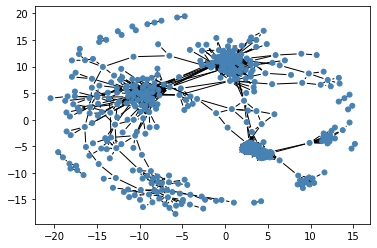

In [7]:
fig, ax = plt.subplots()
ig.plot(g, target=ax, layout=layout)

In [2]:
def get_graph(net, remove_autoconnections=True):
    df = pd.read_csv(base+net+"/patients_edges.csv", index_col=0)
    df.reset_index(inplace=True)
    if remove_autoconnections:
        df = df[df['source'] != df['target']] 
    df_cls =  pd.read_csv(f"{base+net}/patients_classes.csv", index_col=0)
    
    g = ig.Graph.DataFrame(df, directed=False)
    
    
    colors = []
    for patient in g.vs["name"]:

        cls = df_cls.loc[patient, :]['class']

        if cls == "stage1":
            colors.append("green")
        elif cls ==  "stage2":
            colors.append("blue")
        elif cls ==  "stage3":
            colors.append("magenta")
        elif cls ==  "stage4":
            colors.append("red")
        elif cls ==  "control":
            colors.append("yellow")

    g.vs["color"] = colors
    return g




def plot_graph(net, remove_autoconnections=True):
    
    df = pd.read_csv(base+net+"/patients_edges.csv", index_col=0)
    df.reset_index(inplace=True)
    #if remove_autoconnections:
    #    df = df[df['source'] != df['target']] 
    df_cls =  pd.read_csv(f"{base+net}/patients_classes.csv", index_col=0)
    
    g = ig.Graph.DataFrame(df, directed=False)
    
    
    colors = []
    for patient in g.vs["name"]:

        cls = df_cls.loc[patient, :]['class']

        if cls == "stage1":
            colors.append("green")
        elif cls ==  "stage2":
            colors.append("blue")
        elif cls ==  "stage3":
            colors.append("magenta")
        elif cls ==  "stage4":
            colors.append("red")
        elif cls ==  "control":
            colors.append("yellow")

    g.vs["color"] = colors
    
    
    if remove_autoconnections:
        for i in range(len(g.vs)):
            g.delete_edges([(i,i)])
    
    """
    edge_colors = []
    for e in g.es:
        if e['weight'] >= 0:
            edge_colors.append("black")
        else:
            edge_colors.append("orange")
    g.es["color"] = edge_colors
    """
    for e in g.es:
        n1, n2 = e.tuple
        if g.vs[n1]['color'] == g.vs[n2]['color']:
            e['color'] = 'black'
        else:
            e['color'] = 'orange'
    
    
    layout = g.layout(layout='auto')
    out = ig.plot(g, layout = layout, bbox = (700, 700), margin = 10, vertex_size=10)
    if remove_autoconnections:
        out.save(base+net+"/graph_plot.png")
    else:
        out.save(base+net+"/graph_plot_autoconnections.png")
    return out, g


def get_graph_cis(g):
    
    ci_total = len(g.es)
    ci_right = 0
    
    colors = {
        "yellow": 0,
        "yellow_match": 0,
        "green": 0,
        "green_match": 0,
        "blue": 0,
        "blue_match": 0,
        "magenta": 0,
        "magenta_match": 0,
        "red": 0,
        "red_match": 0
    }
    
    for e in g.es:
        n1, n2 = e.tuple
        n1 = g.vs[n1]
        n2 = g.vs[n2]

        colors[n1["color"]] +=1
        colors[n2["color"]] +=1
        if colors[n1["color"]] == colors[n2["color"]]:
            colors[n2["color"]] -= 1
            colors[n2["color"]+"_match"] += 1
            ci_right +=1
    
    return (ci_right/ci_total, colors["yellow_match"]/colors["yellow"], 
            colors["green_match"]/colors["green"], colors["blue_match"]/colors["blue"],
            colors["magenta_match"]/colors["magenta"], colors["red_match"]/colors["red"])


def get_graph_ces(cis):
    ces = [(-1*ci)+1 for ci in cis]
    return ces

def get_ci_ce_dfs():
    ci_dict = {}
    ce_dict = {}
    for n in nets:
        g = get_graph(n)
        cis = get_graph_cis(g)
        ces = get_graph_ces(cis)
        ci_dict[n] = [ci for ci in cis]
        ce_dict[n] = [ce for ce in ces]

    cols = ["Total", "Normal", "Stage 1", "Stage 2", "Stage 3", "Stage 4"]

    ci_df = pd.DataFrame.from_dict(ci_dict).T
    ci_df.columns = cols
    ce_df = pd.DataFrame.from_dict(ce_dict).T
    ce_df.columns = cols
    
    return ci_df, ce_df


def plot_cis():
    sns.set_theme(style="whitegrid")
    ci_df, _ = get_ci_ce_dfs()
    dfs = []
    
    for i, net in enumerate(nets):
        cis = ci_df.iloc[[i], :].values[0]
        cls = ci_df.columns.values
        df = pd.DataFrame()
        df['CI'] = cis
        df['Class'] = cls
        df['Network'] = [net]*len(v)
        dfs.append(df)
        
        cis_plt = sns.barplot(x="Class", y="CI", data=df).set_title(net)
        plt.ylim(0, 1)
        plt.savefig(base+net+"/cis.png")
        plt.clf()
    
    df = pd.concat(dfs)
    df_not_total = df.loc[df["Class"] != "Total"]
    sns.barplot(x="Class", y="CI", data=df_not_total, hue="Network").set_title("CI Class Comparison")
    plt.ylim(0, 1)
    plt.savefig(base+"ci_class_comparison.png")
    plt.clf()
    
    
    df_only_total = df.loc[df["Class"] == "Total"]
    sns.barplot(x="Network", y="CI", data=df_only_total).set_title("CI Comparison")
    plt.ylim(0, 1)
    plt.savefig(base+"ci_comparison.png")
    plt.clf()
    
    return 

In [1]:
for n in nets:
    out = plot_graph(n)
    
for n in nets:
    out = plot_graph(n, False)

NameError: name 'nets' is not defined

In [87]:
out = plot_cis()

<Figure size 432x288 with 0 Axes>

In [83]:
ci_df, ce_df = get_ci_ce_dfs()

In [84]:
ce_df['Network'] = ce_df.index.values
ce_df = ce_df.reset_index()
ce_df = ce_df.iloc[:, 2:]
ce_df

,Normal,Stage 1,Stage 2,Stage 3,Stage 4,Network
0,0.044482,0.459568,0.951311,0.898765,0.919492,R1
1,0.044482,0.459568,0.951311,0.898765,0.919492,R2
2,0.044335,0.482456,0.924528,0.942857,0.888889,R3
3,0.302139,0.644063,0.919124,0.900065,0.890476,R4
4,0.889952,0.686755,0.940895,0.907116,0.911652,R5


In [44]:
ce_df.to_csv(base+"ce_radviz.csv", index=False)

In [95]:
ce_df.loc[5] = [0,0,0,0,0, "Center"]
ce_df.loc[6] = [1,1,1,1,1, "Center"]

[]

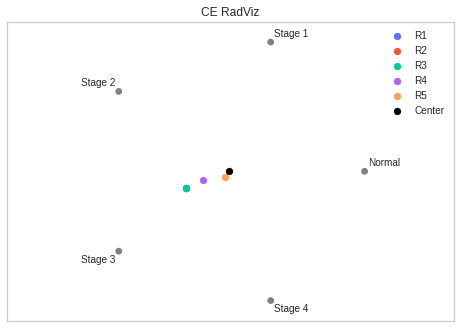

In [96]:
radplot = pd.plotting.radviz(ce_df, 'Network', color=['#636efa', '#ef553b', 
                                                      '#00cc96', '#ab63fa', 
                                                      '#ffa15a', "black"])
radplot.title.set_text('CE RadViz')
radplot.set_xticks([])
radplot.set_yticks([])


In [86]:
ce_df

,Normal,Stage 1,Stage 2,Stage 3,Stage 4,Network
0,0.044482,0.459568,0.951311,0.898765,0.919492,R1
1,0.044482,0.459568,0.951311,0.898765,0.919492,R2
2,0.044335,0.482456,0.924528,0.942857,0.888889,R3
3,0.302139,0.644063,0.919124,0.900065,0.890476,R4
4,0.889952,0.686755,0.940895,0.907116,0.911652,R5


In [23]:
ci_df['Network'] = ci_df.index.values
ci_df = ci_df.reset_index()
ci_df = ci_df.iloc[:, 2:]
ci_df

,Normal,Stage 1,Stage 2,Stage 3,Stage 4,Network
0,0.955518,0.540432,0.048689,0.101235,0.080508,R1
1,0.955518,0.540432,0.048689,0.101235,0.080508,R2
2,0.955665,0.517544,0.075472,0.057143,0.111111,R3
3,0.697861,0.355937,0.080876,0.099935,0.109524,R4
4,0.110048,0.313245,0.059105,0.092884,0.088348,R5


In [27]:
import plotly.graph_objects as go

categories = ci_df.columns.values

fig = go.Figure()


for r in ci_df.iterrows():
    row_cis = r[1].values[:-1]
    row_net = r[1].values[-1]

    fig.add_trace(go.Scatterpolar(
          r=row_cis,
          theta=categories,
          #fill='toself',
          name=row_net
    ))
    

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show()

In [97]:
ce_df

,Normal,Stage 1,Stage 2,Stage 3,Stage 4,Network
0,0.044482,0.459568,0.951311,0.898765,0.919492,R1
1,0.044482,0.459568,0.951311,0.898765,0.919492,R2
2,0.044335,0.482456,0.924528,0.942857,0.888889,R3
3,0.302139,0.644063,0.919124,0.900065,0.890476,R4
4,0.889952,0.686755,0.940895,0.907116,0.911652,R5
5,0.000000,0.000000,0.000000,0.000000,0.000000,Center
6,1.000000,1.000000,1.000000,1.000000,1.000000,Center


In [106]:
pd.Series([0,1,2,3,4,5,5])

0    0
1    1
2    2
3    3
4    4
5    5
6    5
dtype: int64

In [104]:
ser

0    0
1    1
2    2
3    3
4    4
5    5
5    5
dtype: int64

/home/colombelli/.pyenv/versions/3.6.13/lib/python3.6/site-packages/yellowbrick/features/radviz.py:199: RuntimeWarning:

invalid value encountered in true_divide



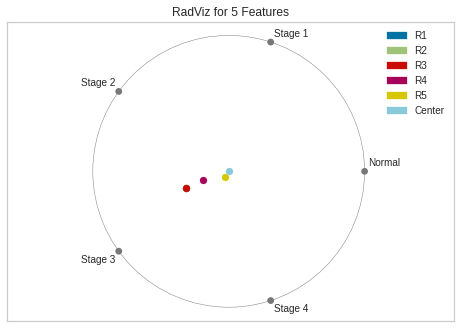

<AxesSubplot:title={'center':'RadViz for 5 Features'}>

In [107]:
visualizer = RadViz(classes=list(ce_df['Network'].values[:-1]))

visualizer.fit(ce_df.iloc[:, :-1], pd.Series([0,1,2,3,4,5,5]))           # Fit the data to the visualizer
visualizer.transform(ce_df.iloc[:, :-1])        # Transform the data
visualizer.show()

In [90]:
ce_df

,Normal,Stage 1,Stage 2,Stage 3,Stage 4,Network
0,0.044482,0.459568,0.951311,0.898765,0.919492,R1
1,0.044482,0.459568,0.951311,0.898765,0.919492,R2
2,0.044335,0.482456,0.924528,0.942857,0.888889,R3
3,0.302139,0.644063,0.919124,0.900065,0.890476,R4
4,0.889952,0.686755,0.940895,0.907116,0.911652,R5


In [ ]:
visualizer.sa

In [72]:
ce_df

,Normal,Stage 1,Stage 2,Stage 3,Stage 4,Network
0,0.044482,0.459568,0.951311,0.898765,0.919492,R1
1,0.044482,0.459568,0.951311,0.898765,0.919492,R2
2,0.044335,0.482456,0.924528,0.942857,0.888889,R3
3,0.302139,0.644063,0.919124,0.900065,0.890476,R4
4,0.889952,0.686755,0.940895,0.907116,0.911652,R5
5,0.000000,0.000000,0.000000,0.000000,0.000000,Center


In [62]:
X

,temperature,relative humidity,light,CO2,humidity
0,23.180,27.2720,426.00,721.25,0.004793
1,23.150,27.2675,429.50,714.00,0.004783
2,23.150,27.2450,426.00,713.50,0.004779
3,23.150,27.2000,426.00,708.25,0.004772
4,23.100,27.2000,426.00,704.50,0.004757
...,...,...,...,...,...
20555,20.815,27.7175,429.75,1505.25,0.004213
20556,20.865,27.7450,423.50,1514.50,0.004230
20557,20.890,27.7450,423.50,1521.50,0.004237
20558,20.890,28.0225,418.75,1632.00,0.004279
